In [1]:
pip install control

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.8/432.8 kB 7.8 MB/s eta 0:00:00


In [2]:
import control

In [3]:
s = control.tf('s')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [144]:
df = pd.read_excel('Grupo 1.xlsx')

In [145]:
df.describe()

,t,y
count,2501.000000,2501.000000
mean,1750.000000,30.345166
std,1010.969169,11.600186
min,0.000000,0.000000
25%,875.000000,27.536396
50%,1750.000000,36.412776
75%,2625.000000,38.100166
max,3500.000000,38.423269


In [146]:
Max_t = df['t'].max()

In [147]:
Delta_t = df._get_value(1, 't') - df._get_value(0, 't')

In [148]:
Count_t = len(df['t'])

## Optimize

In [149]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [150]:
def fun(x):
    global df
    
    Kp = x[0]
    Tau = x[1]
    Delay = x[2]
    
    sys  = Kp/(Tau*s + 1)
    
    num, den = control.pade(Delay, n=2, numdeg=0)
    Pade = control.tf(num, den)
    
    FOPDT = control.series(sys, Pade)
    
    # Simulate step response
    t_fun, y_fun = control.step_response(FOPDT, T=Max_t, T_num=Count_t)
    df_fun = pd.DataFrame({'t_fun':t_fun, 'y_fun':y_fun})
    
    mse = mean_squared_error(df_fun['y_fun'], df['y'])
    return mse

In [151]:
x0 = [1.0, 1.0, 1.0]

In [152]:
bnds = ((0, None), (0, None), (0, None))

In [153]:
res = minimize(fun, x0, method='L-BFGS-B', bounds=bnds, tol=1e-6)

In [154]:
Kp_opt = res.x[0]
Tau_opt = res.x[1]
Delay_opt = res.x[2]

sys  = Kp_opt/(Tau_opt*s + 1)

num, den = control.pade(Delay_opt, n=2, numdeg=0)
Pade = control.tf(num, den)
    
sys_opt = control.series(sys, Pade)

In [155]:
print('Kp=', Kp_opt)
print('Tau=', Tau_opt)
print('Delay=', Delay_opt)

Kp= 38.50007891180355
Tau= 529.9924965686687
Delay= 211.99245536262646


## Plots

In [156]:
t_opt, y_opt = control.step_response(sys_opt, T=Max_t, T_num=Count_t)

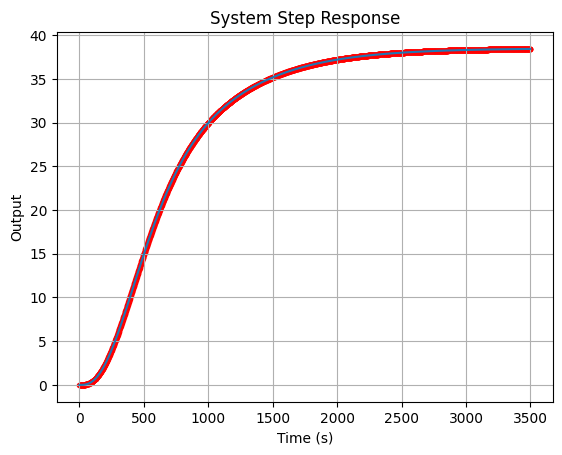

In [157]:
# Plot step response
plt.plot(t_opt,y_opt)
plt.scatter(df['t'], df['y'], marker= ".", color = "red")
plt.xlabel('Time (s)')
plt.ylabel('Output')
plt.title('System Step Response')
plt.grid()
plt.show()